In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from IPython.display import Image
import cv2 as cv
import os
import pydot
from tensorflow.keras.layers import Dropout
from skimage.metrics import peak_signal_noise_ratio ,structural_similarity,mean_squared_error
import pickle
import sys
sys.path.append('/kaggle/input/imd_precip_library/other/default/5')
from Data_processing_zero import Data_Processing as dp
from Data_processing_zero import Training as tn

# Data Processing and Visualisation

In [2]:
SR_file_path = '/kaggle/input/imd-lr-sr/data/data.pkl'
with open(SR_file_path, 'rb') as file:
    SR_data = pickle.load(file)

In [3]:
SR_data_base,Metadata = dp.process_base_data(SR_data)

In [4]:
SR_data_processed,LR_data_processed,Metadata,daily_max = dp.generate_dataset(SR_data_base,Metadata)

Step 1 completed
Step 2 completed
Step 3 completed
Step 4 completed
Step 5 completed


In [5]:
SR_mask,LR_mask = dp.create_mask([SR_data_base[0]])

32 32
(32, 32)


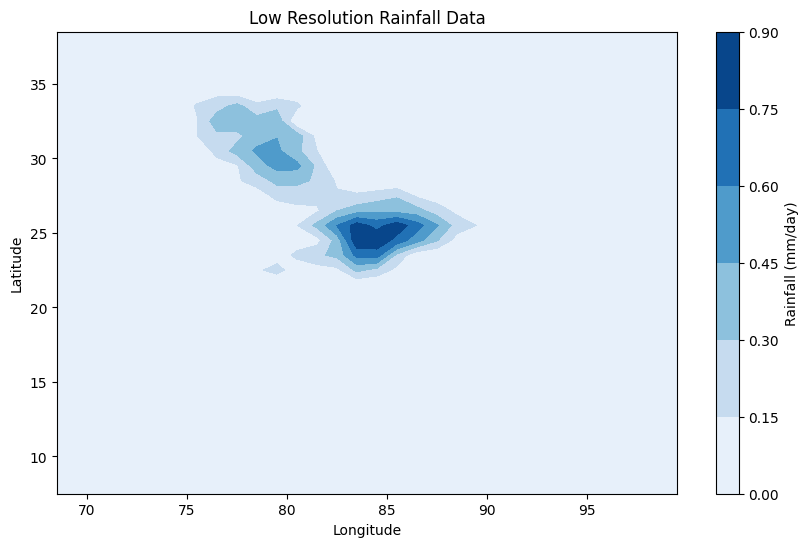

128 128


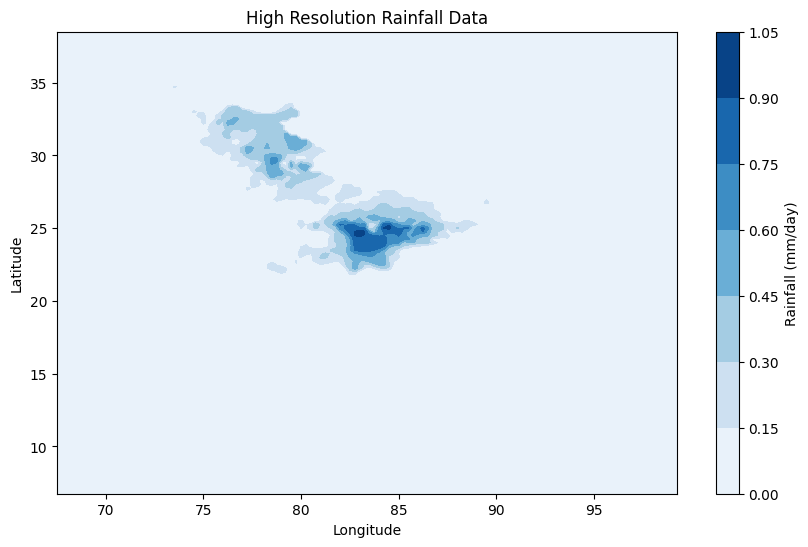

In [6]:
dp.visualize_LR_data(LR_data_processed[0])
dp.visualize_SR_data(SR_data_processed[0])

# Generator

In [7]:
class DepthToSpaceLayer(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(DepthToSpaceLayer, self).__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.block_size)
def residual_block_gen(ch=64, k_s=3, st=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(negative_slope = 0.2),
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(negative_slope = 0.2),
    ])
    return model
def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same')(x)
    x = DepthToSpaceLayer(block_size=2)(x)  
    x = tf.keras.layers.LeakyReLU(negative_slope = 0.2)(x)
    return x
input_lr = tf.keras.layers.Input(shape=(None, None, 1))
input_conv = tf.keras.layers.Conv2D(64, 3
                                    , padding='same')(input_lr)
input_conv = tf.keras.layers.LeakyReLU(negative_slope = 0.2)(input_conv)
Generator = input_conv
for _ in range(8):
    res_output = residual_block_gen()(Generator)
    res_output_1 = residual_block_gen(64,5)(Generator)
    res_output_2 = residual_block_gen(64,7)(Generator)
    res_output_3= residual_block_gen(64,9)(Generator)
    Generator = tf.keras.layers.Add()([Generator, res_output,res_output_1,res_output_2,res_output_3])
Generator = tf.keras.layers.Conv2D(64, 3, padding='same')(Generator)
Generator = tf.keras.layers.BatchNormalization()(Generator)

Generator = tf.keras.layers.Add()([Generator, input_conv])

Generator = Upsample_block(Generator)  
Generator = Upsample_block(Generator) 
output_sr = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(Generator)

Generator = tf.keras.models.Model(input_lr, output_sr)
Generator.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        640 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, None,      │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None,      │     74,368 │ leaky_re_lu[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None,      │    205,440 │ leaky_re_lu[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None,      │    402,048 │ leaky_re_lu[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None,      │    664,192 │ leaky_re_lu[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ leaky_re_lu[0][0… │
│                     │ None, 64)         │            │ sequential[0][0], │
│                     │                   │            │ sequential_1[0][… │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None,      │     74,368 │ add[0][0]         │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None,      │    205,440 │ add[0][0]         │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, None,      │    402,048 │ add[0][0]         │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, None,      │    664,192 │ add[0][0]         │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ add[0][0],        │
│                     │ None, 64)         │            │ sequential_4[0][… │
│                     │                   │            │ sequential_5[0][… │
│                     │                   │            │ sequential_6[0][… │
│                     │                   │            │ sequential_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, None,      │     74,368 │ add_1[0][0]       │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, None,      │    205,440 │ add_1[0][0]     

 Total params: 11,102,209 (42.35 MB)

 Trainable params: 11,093,889 (42.32 MB)

 Non-trainable params: 8,320 (32.50 KB)

# Discriminator

In [8]:
def residual_block_disc(ch=64, k_s=3, st=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch, k_s, strides=(st, st), padding='same',
                               kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.LeakyReLU(negative_slope=0.2),
        # Optional: Move BatchNormalization after activation or remove
        # tf.keras.layers.BatchNormalization(),
    ])
    return model

input_lr = tf.keras.layers.Input(shape=(128, 128, 1))
input_conv = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(input_lr)
input_conv = tf.keras.layers.LeakyReLU(negative_slope=0.2)(input_conv)

channel_nums = [64, 128, 128, 256, 256, 512, 512]
stride_sizes = [2, 1, 2, 1, 2, 1, 2]

disc = input_conv
for x in range(7):
    disc = residual_block_disc(ch=channel_nums[x], st=stride_sizes[x])(disc)

disc = tf.keras.layers.Flatten()(disc)
#disc = tf.keras.layers.Droput(0.1)(disc)
disc = tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.HeNormal())(disc)
disc = tf.keras.layers.LeakyReLU(negative_slope=0.2)(disc)
disc_output = tf.keras.layers.Dense(1)(disc) 
discriminator = tf.keras.models.Model(input_lr, disc_output)
discriminator.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_67 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_33 (Sequential)      │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_34 (Sequential)      │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_35 (Sequential)      │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_36 (Sequential)      │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_37 (Sequential)      │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_38 (Sequential)      │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_75 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,240,705 (145.88 MB)

 Trainable params: 38,240,705 (145.88 MB)

 Non-trainable params: 0 (0.00 B)

# Feature Extractor

In [9]:
from keras.models import load_model
def my_custom_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.9 * ssim_loss + 0.1* mse_loss
model = load_model('/kaggle/input/autoencoder_zero/tensorflow2/default/1/autoencoder_fe (1).keras',custom_objects={'combined_loss': my_custom_loss})
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('latent_space').output)

# Training

In [10]:
PSNR = []
SSIM = []
MSE = []

generator_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.0, beta_2=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.0, beta_2=0.5)

def train_step(SR_images, LR_images, batch_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = Generator(LR_images, training=True)
        real_output = discriminator(SR_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        gp = tn.gradient_penalty(discriminator, SR_images, fake_images)
        gen_loss = tn.generator_loss(fake_output, SR_images, fake_images, feature_extractor)
        disc_loss = tn.discriminator_loss(real_output, fake_output, gp)
    
    # Compute gradients for the generator, discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, Generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients to update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, Generator.trainable_variables ))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(SR_data, LR_data,PSNR,SSIM, epochs, batch_size):
    for epoch in range(epochs):
        indices = np.arange(len(SR_data))
        np.random.shuffle(indices)
        for i in range(len(SR_data)//batch_size):
            batch = indices[i:i+batch_size]
            lr = np.array([LR_data[j] for j in batch]).reshape((batch_size, 32, 32, 1))
            sr = np.array([SR_data[j] for j in batch]).reshape((batch_size, 128, 128, 1))
            gen_loss, disc_loss = train_step(sr, lr, batch_size)
            if i%100==0 and i!=0:
                print(f'{i} batches completed in epoch:{epoch+1}')
        sr_pic = np.array(SR_data[0])
        lr_pic = np.array(LR_data[:32]).reshape((32, 32, 32, 1))
        generated = np.array(Generator(lr_pic))[0].reshape((128,128))
        dp.visualize_SR_masked_data(sr_pic,SR_mask[0])
        dp.visualize_SR_masked_data(generated,SR_mask[0])
        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
        Generator.save(f'generator_epoch_{epoch+1}.h5')
        discriminator.save(f'discriminator_epoch_{epoch+1}.h5')
        print(f'Models saved after epoch {epoch+1}')
        psnr,ssim , mse = tn.calculate_metrics(Generator,SR_data,LR_data ,SR_mask[0])
        print(f'PSNR:{psnr},SSIM:{ssim} , MSE:{mse}')
        PSNR.append(psnr)
        SSIM.append(ssim)
        MSE.append(mse)

100 batches completed in epoch:1
200 batches completed in epoch:1
300 batches completed in epoch:1
400 batches completed in epoch:1
500 batches completed in epoch:1
600 batches completed in epoch:1
700 batches completed in epoch:1
800 batches completed in epoch:1
900 batches completed in epoch:1
1000 batches completed in epoch:1
1100 batches completed in epoch:1
1200 batches completed in epoch:1
1300 batches completed in epoch:1
128 128


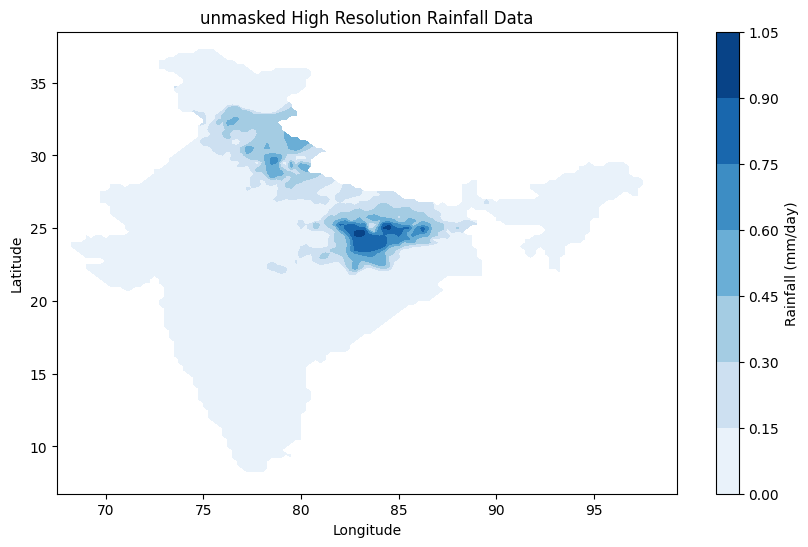

128 128


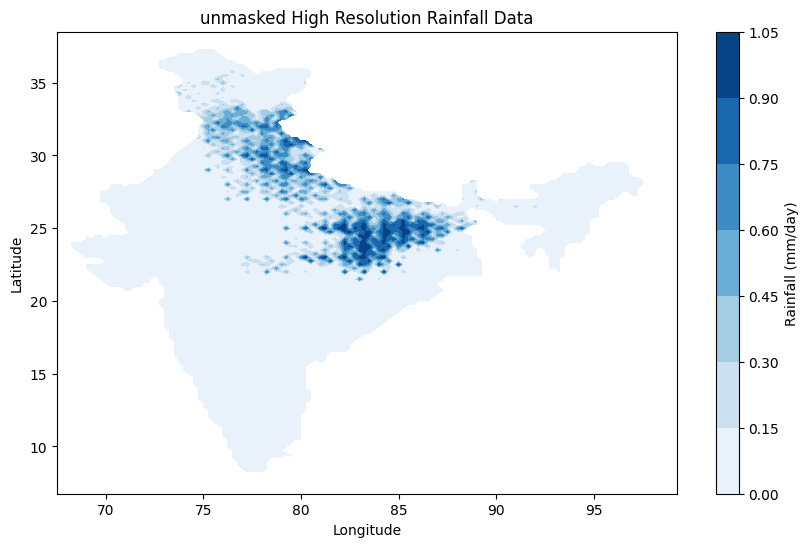

Epoch 1, Generator Loss: 695.798828125, Discriminator Loss: -6.897233963012695
Models saved after epoch 1
PSNR:28.859059741638717,SSIM:0.9074992238026585 , MSE:0.001887318312578371
100 batches completed in epoch:2
200 batches completed in epoch:2
300 batches completed in epoch:2
400 batches completed in epoch:2
500 batches completed in epoch:2
600 batches completed in epoch:2
700 batches completed in epoch:2
800 batches completed in epoch:2
900 batches completed in epoch:2
1000 batches completed in epoch:2
1100 batches completed in epoch:2
1200 batches completed in epoch:2
1300 batches completed in epoch:2
128 128


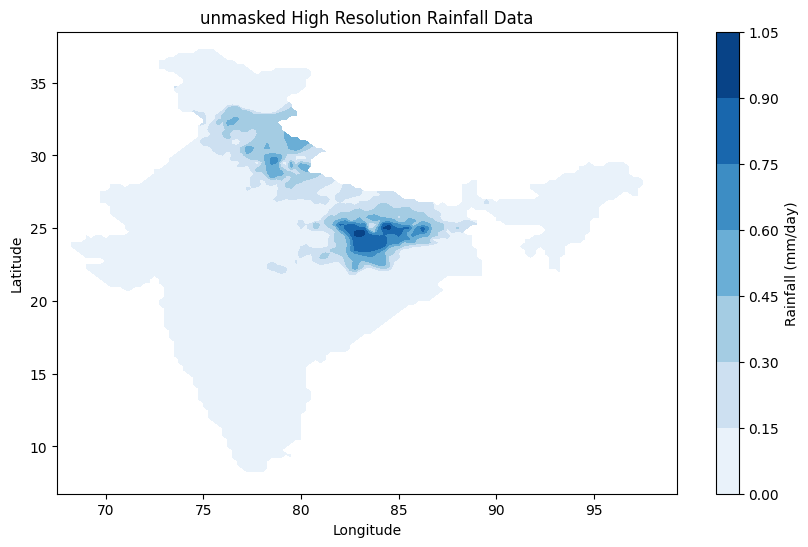

128 128


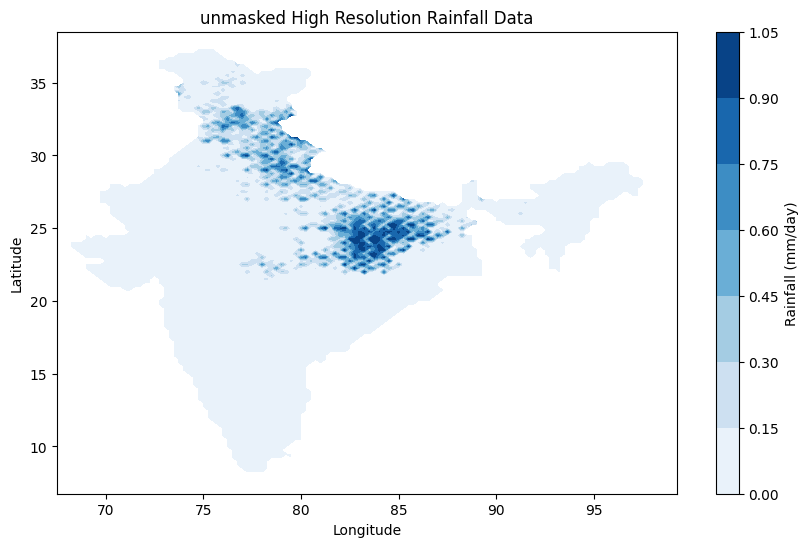

Epoch 2, Generator Loss: 506.47979736328125, Discriminator Loss: -4.171055316925049
Models saved after epoch 2
PSNR:29.117218245645887,SSIM:0.9108311067816802 , MSE:0.0017475614660209784
100 batches completed in epoch:3
200 batches completed in epoch:3
300 batches completed in epoch:3
400 batches completed in epoch:3
500 batches completed in epoch:3
600 batches completed in epoch:3
700 batches completed in epoch:3
800 batches completed in epoch:3
900 batches completed in epoch:3
1000 batches completed in epoch:3
1100 batches completed in epoch:3
1200 batches completed in epoch:3
1300 batches completed in epoch:3
128 128


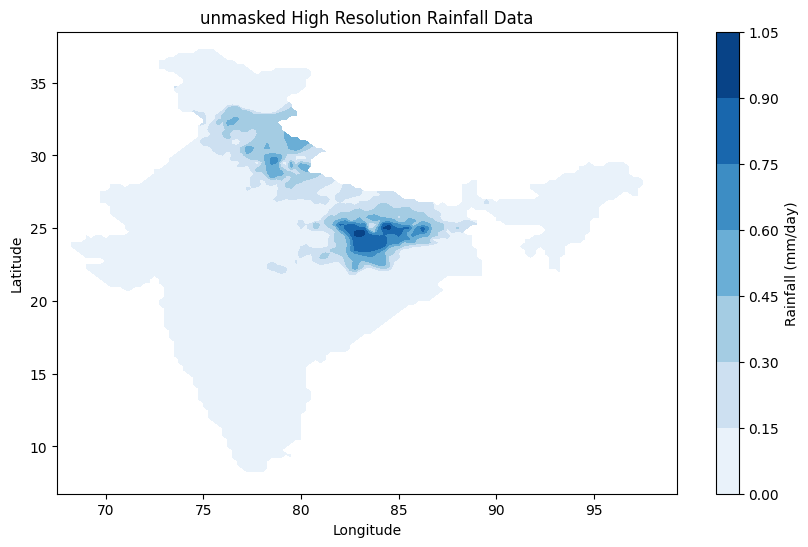

128 128


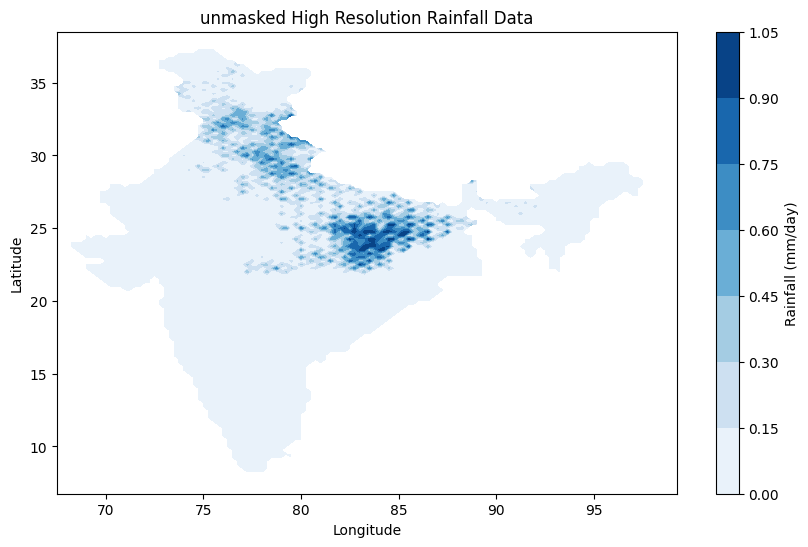

Epoch 3, Generator Loss: 502.1347961425781, Discriminator Loss: -5.842264175415039
Models saved after epoch 3
PSNR:29.588142534095255,SSIM:0.9102204806229016 , MSE:0.0015342721884273704
100 batches completed in epoch:4
200 batches completed in epoch:4
300 batches completed in epoch:4
400 batches completed in epoch:4
500 batches completed in epoch:4
600 batches completed in epoch:4
700 batches completed in epoch:4
800 batches completed in epoch:4
900 batches completed in epoch:4
1000 batches completed in epoch:4
1100 batches completed in epoch:4
1200 batches completed in epoch:4
1300 batches completed in epoch:4
128 128


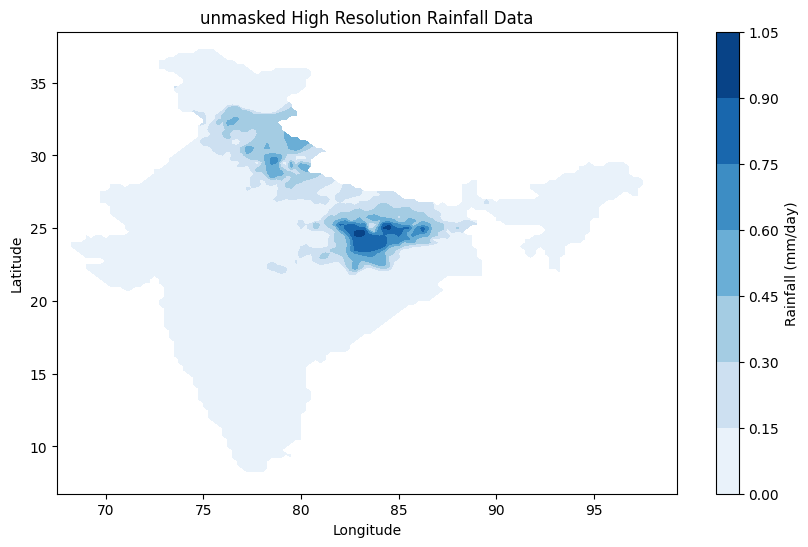

128 128


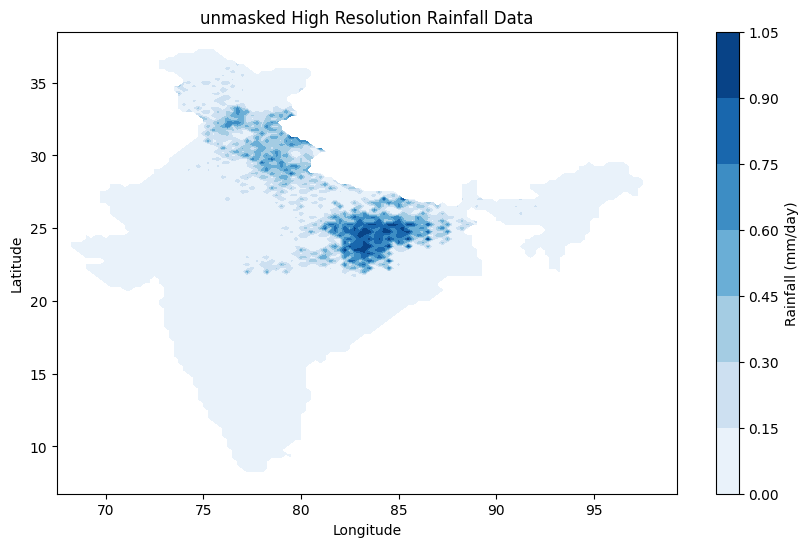

Epoch 4, Generator Loss: 432.1810302734375, Discriminator Loss: -6.071988105773926
Models saved after epoch 4
PSNR:30.425274881553804,SSIM:0.9184472922725752 , MSE:0.001254241191744586
100 batches completed in epoch:5
200 batches completed in epoch:5
300 batches completed in epoch:5
400 batches completed in epoch:5
500 batches completed in epoch:5
600 batches completed in epoch:5
700 batches completed in epoch:5
800 batches completed in epoch:5
900 batches completed in epoch:5
1000 batches completed in epoch:5
1100 batches completed in epoch:5
1200 batches completed in epoch:5
1300 batches completed in epoch:5
128 128


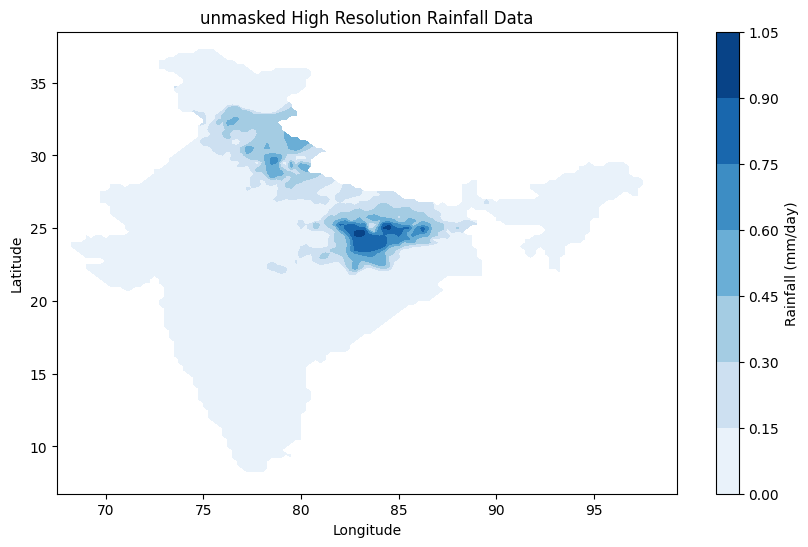

128 128


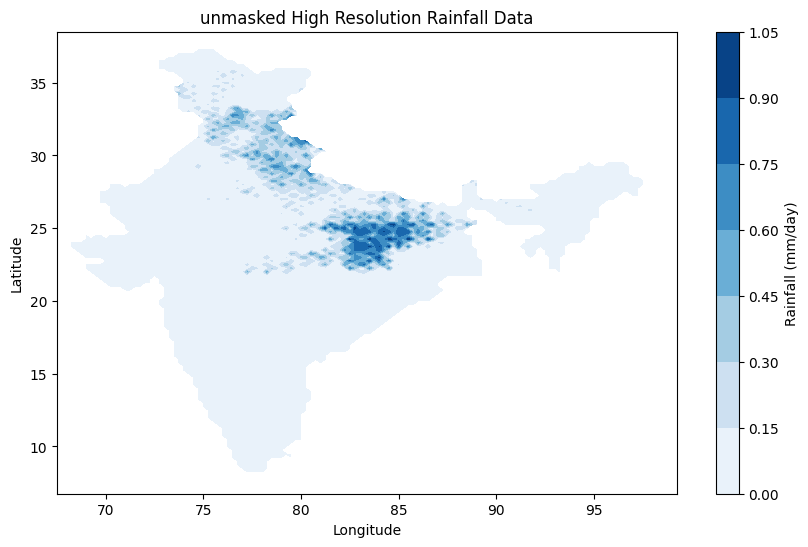

Epoch 5, Generator Loss: 378.13555908203125, Discriminator Loss: -5.728672504425049
Models saved after epoch 5
PSNR:30.472794389677897,SSIM:0.9169508296974735 , MSE:0.0012236391102119501


In [11]:
train(SR_data_processed,LR_data_processed,PSNR,SSIM,epochs=5, batch_size=32)

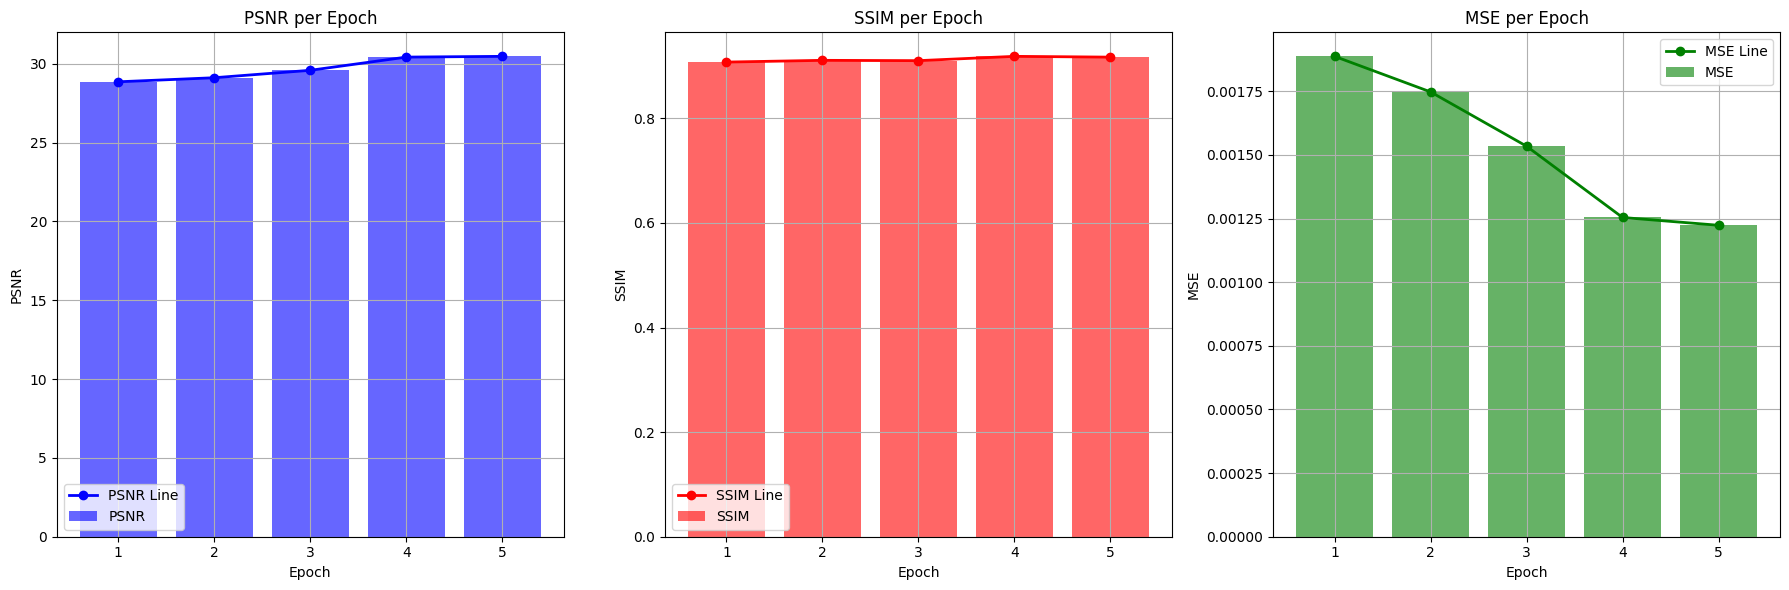

In [12]:
tn.plot_metrics(PSNR,SSIM,MSE)

In [74]:
HR = Generator(np.array(SR_data_processed[0]).reshape((1,128,128,1)))
HR = np.array(HR).reshape(512,512)

In [75]:
import tensorflow as tf
import numpy as np
from scipy.ndimage import gaussian_filter

# First upsample using the original method
upsampled_image = tf.keras.layers.UpSampling2D(size=(2, 2))(SR_data_base[0].reshape((1, 128, 128, 1)))
upsampled_image = tf.keras.layers.UpSampling2D(size=(2, 2))(upsampled_image)

# Convert the result to numpy array for applying Gaussian blur
upsampled_image_np = upsampled_image.numpy()

# Apply Gaussian blur to smooth the edges
# Adjust sigma as per need (start with 0.5 for minimal smoothing)
smoothed_image = gaussian_filter(upsampled_image_np, sigma=0.5)

# Create mask for NaN values if needed
mask = np.isnan(smoothed_image)

In [76]:
HR[mask.reshape(512,512)] = np.nan

128 128


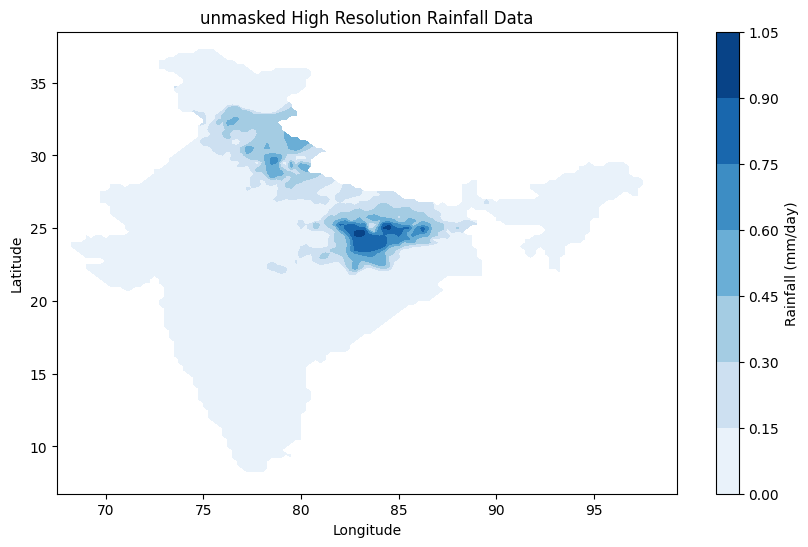

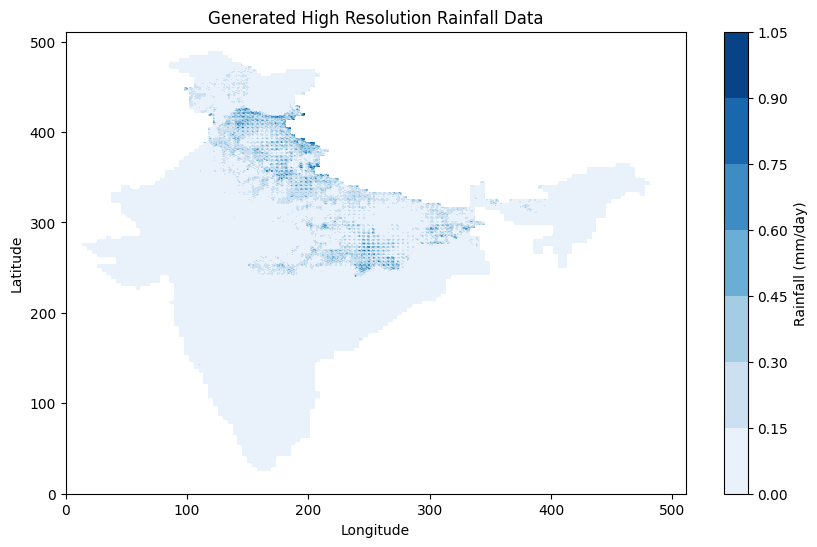

In [77]:
dp.visualize_SR_masked_data(SR_data_processed[0],SR_mask[0])
lat25 = np.load('/kaggle/input/coordinates-imd/0.25lat.npy')
lon25 = np.load('/kaggle/input/coordinates-imd/0.25lon.npy')[4:-4]
lon = np.arange(len(lon25) * 4)
lat = np.arange(len(lat25) * 4)
X_SR, Y_SR = np.meshgrid(lon, lat)
plt.figure(figsize=(10, 6))   
plt.contourf(X_SR, Y_SR,HR , cmap='Blues')
plt.colorbar(label='Rainfall (mm/day)')
plt.title('Generated High Resolution Rainfall Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()